# Exercise 1.7

In [2]:
using LinearAlgebra
using SparseArrays
using Plots
using Polynomials

In [22]:
u_analytical(x) = exp(-800*(x - 0.4)^2) + 0.25*exp(-40*(x - 0.8)^2) 
f(x) = (-1601)*exp(-800*(x - 0.4)^2) + (-1600*x + 640.0)^2*exp(-800*(x - 0.4)^2) - 20.25*exp(-40*(x - 0.8)^2) + 0.25*(-80*x + 64.0)^2*exp(-40*(x - 0.8)^2)

f (generic function with 1 method)

## b

In [4]:
function errorestimate(
    xc::Vector{Float64},
    xf::Vector{Float64},
    uhc::Vector{Float64},
    uhf::Vector{Float64},
    EToVc::Matrix{Int64},
    EToVf::Matrix{Int64},
    idxMarked::Vector{Int64}
)::Vector{Float64}
    K = length(idxMarked)
    err = zeros(K)

    for k in 1:K
        i = idxMarked[k]
        j = i + k - 1
        h = xc[i+1] - xc[i]

        err[i] = sqrt(3)*sqrt(2)*sqrt(h*(2*uhf[j+1]^2 + (uhf[j] - 3*uhc[i] + uhf[j+2] - 3*uhc[i+1])*uhf[j+1] + 2*uhc[i+1]^2 + (-uhf[j]/2 + 2*uhc[i] - (5*uhf[j+2])/2)*uhc[i+1] + uhf[j]^2 - (5*uhc[i]*uhf[j])/2 + 2*uhc[i]^2 - uhc[i]*uhf[j+2]/2 + uhf[j+2]^2))/6
    end

    return err
end

    

errorestimate (generic function with 1 method)

## c

In [5]:
function refine_marked(EToVcoarse::Matrix{Int64}, xcoarse::Vector{Float64}, idxMarked::Vector{Int64})::Tuple{Matrix{Int64}, Vector{Float64}}
    M, N = size(EToVcoarse)
    K = length(idxMarked)

    EToVfine = zeros((M + K, N))
    xfine = zeros(length(xcoarse) + K)

    i = 1
    for j in 1:M
        xfine[j+i-1] = xcoarse[j]
        EToVfine[j+i-1, :] = [j+i-1, j+i]

        if i <= K && idxMarked[i] == j
            xfine[j+i] = (xcoarse[j+1] + xcoarse[j])/2
            EToVfine[j+i, :] = [j+i, j+i+1]
            i += 1
        end
    end

    xfine[end] = xcoarse[end]

    return EToVfine, xfine
end

refine_marked (generic function with 1 method)

## e

In [6]:
function BVPDrhs(L,c,d,x,f)
    # Purpose: Solve second-order boundary value problem using FEM.
    # Author(s): Clara Hollenbeck
    # INPUT PARAMETERS
    # L : Domain length
    # c : Left boundary condition
    # d : Right boundary condition
    # x : 1D mesh vector x(1:{M})
    
    ## GLOBAL ASSEMBLY
    # Assemble A (the upper triangle only) and b. (Algorithm 1)
    M = length(x)
    A = spzeros(M,M)
    b = zeros(M)

    for i = 1 : M-1
        h = x[i+1] - x[i]
        k1 = 1/h + h/3
        k2 = -1/h + h/6
    
        A[i,i] += k1
        A[i, i+1] += k2
        A[i+1, i] += k2
        A[i+1,i+1] += k1
    end


    for i in 2:M-1
        h1 = x[i+1] - x[i]
        h2 = x[i]-x[i-1]
        b[i] = -f(x[i-1])*h1/6 - f(x[i])*(h1 + h2)/3 - f(x[i+1])*h2/6
    end
    # IMPOSE BOUNDARY CONDITIONS
    b[1] = c
    b[2] -= A[1,2]*c
    A[1,1] = 1
    A[1,2] = 0
    A[2,1] = 0

    b[M] = d
    b[M-1] -= A[M-1, M]*d
    A[M,M] = 1
    A[M-1,M] = 0
    A[M,M-1] = 0

    # SOLVE SYSTEM
    u = A\b

    return u
end

BVPDrhs (generic function with 1 method)

In [7]:
function UBVPDrhs(L,c,d,M,fun)
    x = collect(range(0, L, M))
    u = BVPDrhs(L,c, d, x, fun)
    return u, x
end



UBVPDrhs (generic function with 1 method)

1.9996162751722517

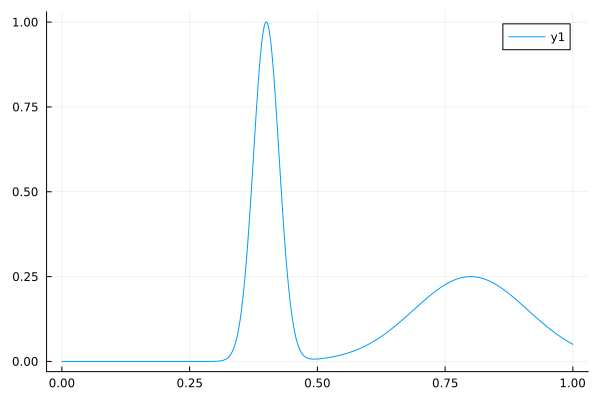

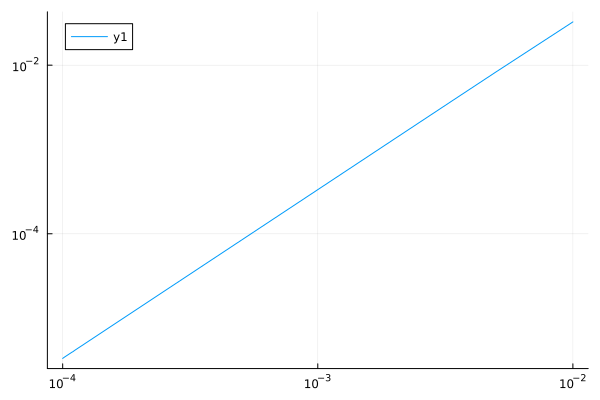

In [8]:
function uhat(x::Float64, xs::Vector{Float64}, us::Vector{Float64}) :: Float64
    i = max(searchsortedfirst(xs, x) - 1, 1)
    h = xs[i+1] - xs[i]
    
    N1 = 1 - (x - xs[i]) / h
    N2 = (x - xs[i]) / h

    return us[i] * N1 + us[i+1] * N2
end

function uhat(x::Vector{Float64}, xs::Vector{Float64}, us::Vector{Float64}) :: Vector{Float64}
    return uhat.(x, Ref(xs), Ref(us))
end

c = 0
d = 0.05047412950
L = 1.0

x = collect(range(0,1,10000))
us = BVPDrhs(1, c, d, x, f)
plt = plot(x, us)

iterations = 100
step_size = 100
granularity = 100000

hs = zeros(iterations)
max_errors = zeros(iterations)

x_values = collect(range(0, L, granularity))

for i in 1:iterations
    M = i*step_size
    uhat_points, x_points = UBVPDrhs(L, c, d, M, f)
    error(x) = abs(uhat(x, x_points, uhat_points) - u_analytical.(x))

    hs[i] = L / M
    max_errors[i] = maximum(error.(x_values))
end

display(fit(log.(hs), log.(max_errors), 1)[1])
display(plt)
plot(hs, max_errors, xscale=:log10, yscale=:log10)


## f

In [9]:
function AMR(L, c, d, f, a)
    xc = [0.0, L]
    EToVc = [1 2]
    tol = 10^(-4)
    iterations = 20
    error = zeros(iterations)
    DOF = zeros(iterations)


    for i in 1:iterations
        EToVf, xf = refine_marked(EToVc,xc, EToVc[1:end, 1])
        uc = BVPDrhs(L,c,d,xc,f)
        uf = BVPDrhs(L,c,d,xf,f)
        err = errorestimate(xc,xf,uc,uf,EToVc,EToVf,EToVc[1:end, 1])
        idxMarked = findall(err .> a*tol)

        error[i] = norm(err)
        DOF[i] = length(xc)


        if isempty(idxMarked)
            error = error[1:i]
            DOF = DOF[1:i]
            break
        else
            EToVc, xc = refine_marked(EToVc,xc,idxMarked)
            
        end
    end

    return xc, EToVc, error, DOF
end



AMR (generic function with 1 method)

1077

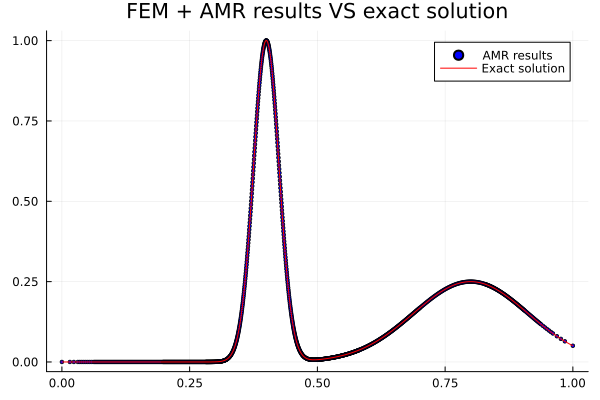

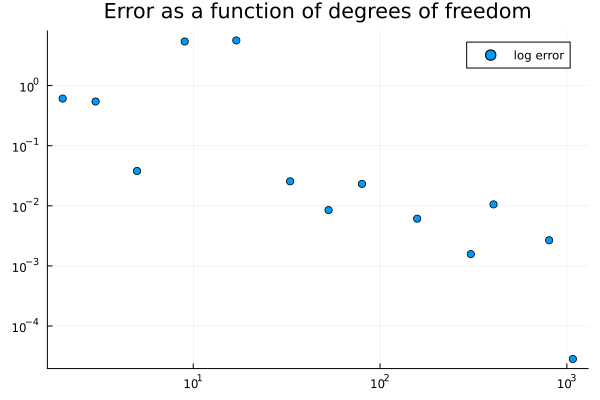

In [34]:
VX, EVoT, err, DOF = AMR(L, c, d, f, 1.0)
x = collect(range(0,1,10000))
us = BVPDrhs(1, c, d, VX, f)
error_plt = plot(DOF, err, seriestype=:scatter, xscale=:log10, yscale=:log10, label = "log error")
title!("Error as a function of degrees of freedom")
#plot!(fit(DOF,err, 2),  xscale=:log10, yscale=:log10)
#plot!(x, (x.^2) .+1, xscale=:log10, yscale=:log10)
plt = plot(VX, us, seriestype=:scatter, mc=:blue, ms=2, label = "AMR results")

plot!(x, u_analytical.(x), lc=:red, label = "Exact solution")
title!("FEM + AMR results VS exact solution")
#vline!(VX)
display(length(VX))
display(plt)
display(error_plt)


6709

14

6.79427618187851e-8

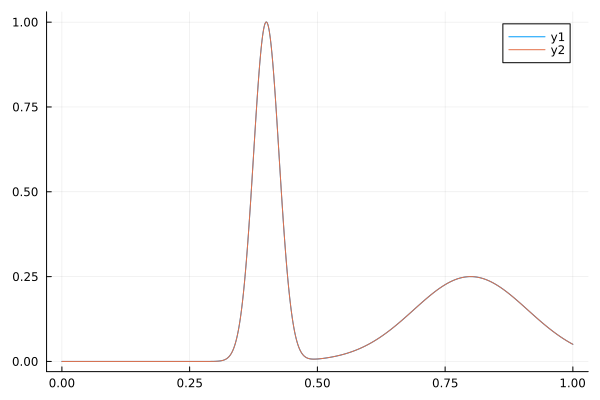

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\clar1\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\clar1\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\clar1\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\clar1\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191


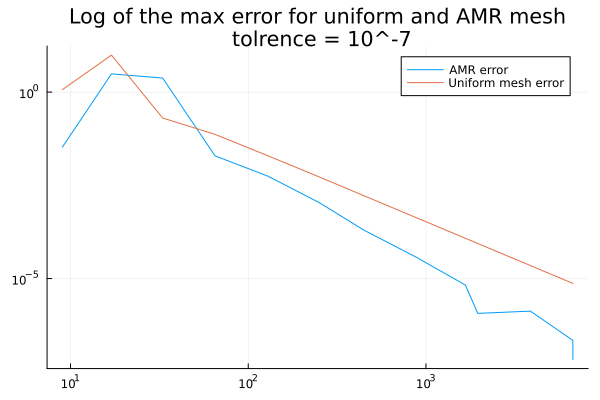

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\clar1\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\clar1\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\clar1\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191


-2.6339761623732882

-1.9906697090224925

In [35]:
tolerance = 10^(-7)
M = 3
xc = collect(range(0,1,M))
EToVc = hcat(1:M-1,2:M)
EToVf, xf = refine_marked(EToVc,xc,collect(1:length(xc)-1))
uc = BVPDrhs(L,c,d,xc,f)
uf = BVPDrhs(L,c,d,xf,f)
errors = errorestimate(xc,xf,uc,uf,EToVc,EToVf,collect(1:length(xc)-1))
idxMarked = findall(errors .>= tolerance)
EToVc, xc = refine_marked(EToVc,xc,idxMarked)
count = 1
max_errors = []
DOF = []
while !isempty(idxMarked) && count < 100
    count += 1
    EToVf, xf = refine_marked(EToVc,xc,collect(1:length(xc)-1))
    uc = BVPDrhs(L,c,d,xc,f)
    uf = BVPDrhs(L,c,d,xf,f)
    errors = errorestimate(xc,xf,uc,uf,EToVc,EToVf,collect(1:length(xc)-1))
    idxMarked = findall(errors .>= tolerance)
    EToVc, xc = refine_marked(EToVc,xc,idxMarked)
    push!(max_errors, maximum(errors))
    push!(DOF, length(xc))
end
uc = BVPDrhs(L,c,d,xc,f)

display(length(xc))
display(count)
display(maximum(errors))

x_plot = collect(range(0,L,10000))
p1 = plot(x_plot,uhat(x_plot,xc,uc))
plot!(x_plot,u_analytical.(x_plot))
#vline!(xc)
display(p1)

p2 = plot(DOF,max_errors,xscale=:log10,yscale=:log10, label = "AMR error")

x_values = collect(range(0, stop=L, length=100000))
N = length(DOF)
DOF1 = zeros(N)
max_errors1 = zeros(N)
for i in 1:N
    M = DOF[i]
    u_coefs, x_points = UBVPDrhs(L,c,d,M,f)
    errors = abs.(u_analytical.(x_values)-uhat(x_values,x_points,u_coefs))
    DOF1[i] = length(x_points)
    max_errors1[i] = maximum(errors)
end

plot!(DOF1,max_errors1,scale=:log10,yscale=:log10, label = "Uniform mesh error")
title!("Log of the max error for uniform and AMR mesh\n tolrence = 10^-7")
display(p2)

coefficient = fit(log.(DOF[4:end]), log.(max_errors[4:end]), 1)[1]
display(coefficient)
coefficient = fit(log.(DOF1[4:end]), log.(max_errors1[4:end]), 1)[1]
display(coefficient)
